# Введение

В этом задании Вы продолжите работать с данными из семинара [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

In [3]:
import pandas as pd
import numpy as np
import math

## Загрузка и предобработка данных

Загрузим данные и проведем предобраотку данных как на семинаре.

In [4]:
!wget -q -N https://www.dropbox.com/s/z8syrl5trawxs0n/articles.zip?dl=0 -O articles.zip
!unzip -o -q articles.zip

In [5]:
articles_df = pd.read_csv('articles/shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


In [6]:
interactions_df = pd.read_csv('articles/users_interactions.csv')
interactions_df.head(2)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US


In [7]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

In [8]:
# зададим словарь определяющий силу взаимодействия
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

interactions_df['eventStrength'] = interactions_df.eventType.apply(lambda x: event_type_strength[x])

Оставляем только тех пользователей, которые произамодействовали более чем с пятью статьями.

In [9]:
users_interactions_count_df = (
    interactions_df
    .groupby(['personId', 'contentId'])
    .first()
    .reset_index()
    .groupby('personId').size())
print('# users:', len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions:',len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


Оставляем только те взаимодействия, которые относятся к отфильтрованным пользователям.

In [10]:
interactions_from_selected_users_df = interactions_df.loc[np.in1d(interactions_df.personId,
            users_with_enough_interactions_df)]

In [11]:
print('# interactions before:', interactions_df.shape)
print('# interactions after:', interactions_from_selected_users_df.shape)

# interactions before: (72312, 9)
# interactions after: (69868, 9)


Объединяем все взаимодействия пользователя по каждой статье и сглаживаем полученный результат, взяв от него логарифм.

In [12]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId']).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['personId', 'contentId'])
)
interactions_full_df['last_timestamp'] = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId'])['timestamp'].last()
)
        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(5)

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324


Разобьём выборку на обучение и контроль по времени.

In [13]:
from sklearn.model_selection import train_test_split

split_ts = 1475519530
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

interactions_train_df

# interactions on Train set: 29329
# interactions on Test set: 9777


,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
2,-1007001694607905623,-793729620925729327,1.0,1472834892
6,-1032019229384696495,-1006791494035379303,1.0,1469129122
7,-1032019229384696495,-1039912738963181810,1.0,1459376415
8,-1032019229384696495,-1081723567492738167,2.0,1464054093
...,...,...,...,...
39099,997469202936578234,9112765177685685246,2.0,1472479493
39100,998688566268269815,-1255189867397298842,1.0,1474567164
39101,998688566268269815,-401664538366009049,1.0,1474567449
39103,998688566268269815,6881796783400625893,1.0,1474567675


Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

In [14]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    list() for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(1)

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."


## Библиотека LightFM

Для рекомендации Вы будете пользоваться библиотекой [LightFM](https://making.lyst.com/lightfm/docs/home.html), в которой реализованы популярные алгоритмы. Для оценивания качества рекомендации, как и на семинаре, будем пользоваться метрикой *precision@10*.

In [30]:
!pip install lightfm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

     |████████████████████████████████| 317kB 4.3MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705354 sha256=a25f4c91dbe57302a37d078fc3869b722a19aae91e6acbe43d84194cc31731c6
  Stored in directory: /root/.cache/pip/wheels/c6/64/d4/673c7277f71ac4c5ad4835b94708c01b653ef2d3aa78ef20aa
Successfully built lightfm


## Задание 1. (2 балла)

Модели в LightFM работают с разреженными матрицами. Создайте разреженные матрицы `data_train` и `data_test` (размером количество пользователей на количество статей), такие что на пересечении строки пользователя и столбца статьи стоит сила их взаимодействия, если взаимодействие было, и стоит ноль, если взаимодействия не было.

In [45]:
from scipy.sparse import csr_matrix
from lightfm.data import Dataset

In [ ]:
# Ваш код здесь
# data_train = csr_matrix(pd.pivot_table(
#     interactions_train_df,
#     values='eventStrength',
#     index='personId',
#     columns='contentId').fillna(0))

# data_test = csr_matrix(pd.pivot_table(
#     interactions_test_df,
#     values='eventStrength',
#     index='personId',
#     columns='contentId').fillna(0))

In [ ]:
# data_train

In [ ]:
# data_test

Ранее была ошибка: Incorrect number of features in item_features в случае, если создавал разреженные матрицы путем выше.

Пошел другим путем с помощью этого: https://stackoverflow.com/questions/51144061/how-to-create-a-sparsematrix-from-dataframe-in-a-specific-format

In [32]:
data = Dataset()
data.fit(interactions_full_df.personId.unique(), interactions_full_df.contentId.unique())
interactions_matrix_train, weights_matrix_train = data.build_interactions([tuple(i) for i in interactions_train_df.drop(['last_timestamp'], axis=1).values])
interactions_matrix_test, weights_matrix_test = data.build_interactions([tuple(i) for i in interactions_test_df.drop(['last_timestamp'], axis=1).values])

In [ ]:
interactions_matrix_train

<1140x2984 sparse matrix of type '<class 'numpy.int32'>'
	with 29329 stored elements in COOrdinate format>

In [ ]:
interactions_matrix_test

<1140x2984 sparse matrix of type '<class 'numpy.int32'>'
	with 9777 stored elements in COOrdinate format>

## Задание 2. (1 балл)

Обучите модель LightFM с `loss='warp'` и посчитайте *precision@10* на тесте.

In [ ]:
# Ваш код здесь
lfm = LightFM(loss='warp', random_state=7, k=10)
lfm.fit(interactions=interactions_matrix_train, sample_weight=weights_matrix_train)

In [ ]:
precision_at_10 = precision_at_k(model=lfm, test_interactions=interactions_matrix_test, k=10).mean()
print(f'precision@10 на тесте: {precision_at_10}')

precision@10 на тесте: 0.0032586557790637016


## Задание 3. (3 балла)

При вызове метода `fit` LightFM позволяет передавать в `item_features` признаковое описание объектов. Воспользуемся этим. Будем получать признаковое описание из текста статьи в виде [TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF) (можно воспользоваться `TfidfVectorizer` из scikit-learn). Создайте матрицу `feat` размером количество статей на размер признакового описание и обучите LightFM с `loss='warp'` и посчитайте precision@10 на тесте.

In [ ]:
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


In [37]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [38]:
def tokenize_text(text):
    return word_tokenize(text)

In [39]:
articles_df_unique = articles_df[['contentId', 'text']].drop_duplicates(ignore_index=True)
articles_df_unique

,contentId,text
0,-4110354420726924665,All of this work is still very early. The firs...
1,-7292285110016212249,The alarm clock wakes me at 8:00 with stream o...
2,-6151852268067518688,We're excited to share the Google Data Center ...
3,2448026894306402386,The Aite Group projects the blockchain market ...
4,-2826566343807132236,One of the largest and oldest organizations fo...
...,...,...
3042,9213260650272029784,"A Liga Ventures, aceleradora de startups espec..."
3043,-3295913657316686039,"Amazon has launched Chime, a video conferencin..."
3044,3618271604906293310,"February 9, 2017 - We begin each year with a l..."
3045,6607431762270322325,"At JPMorgan Chase & Co., a learning machine is..."


In [40]:
articles_df_unique.contentId.count() == articles_df_unique.contentId.nunique() # Проверка на то, что в столбце contentId точно находятся уникальные значения

True

In [41]:
# Ваш код здесь
articles_df_unique['text_tokenize'] = articles_df_unique['text'].apply(tokenize_text)
articles_df_unique.head(2)

,contentId,text,text_tokenize
0,-4110354420726924665,All of this work is still very early. The firs...,"[All, of, this, work, is, still, very, early, ..."
1,-7292285110016212249,The alarm clock wakes me at 8:00 with stream o...,"[The, alarm, clock, wakes, me, at, 8:00, with,..."


In [42]:
text = [' '.join(i) for i in articles_df_unique['text_tokenize']]

In [43]:
tfidf_vect = TfidfVectorizer()
feat = tfidf_vect.fit_transform(text)

In [44]:
feat

<3047x72603 sparse matrix of type '<class 'numpy.float64'>'
	with 1061708 stored elements in Compressed Sparse Row format>

In [ ]:
lfm_feat = LightFM(loss='warp', random_state=7, k=10)
lfm_feat.fit(interactions=interactions_matrix_train, sample_weight=weights_matrix_train, item_features=feat)

In [ ]:
precision_at_10_feat = precision_at_k(model=lfm_feat, test_interactions=interactions_matrix_test, k=10, item_features=feat).mean()
print(f'precision@10 на тесте после добавления feat: {precision_at_10_feat}')

precision@10 на тесте после добавления feat: 0.0022403260227292776


## Задание 4. (2 балла)

В задании 3 мы использовали сырой текст статей. В этом задании необходимо сначала сделать предобработку текста (привести к нижнему регистру, убрать стоп слова, привести слова к нормальной форме и т.д.), после чего обучите модель и оценить качество на тестовых данных.

In [ ]:
# Ваш код здесь
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def process_text(text):
    return [lemmatizer.lemmatize(word) for word in word_tokenize(text.lower()) if (word not in string.punctuation) and (word not in stop_words)]

In [ ]:
articles_df_unique['text_process'] = articles_df_unique['text'].apply(process_text)
articles_df_unique.head(2)

,contentId,text,text_tokenize,text_process
0,-4110354420726924665,All of this work is still very early. The firs...,"[All, of, this, work, is, still, very, early, ...","[work, still, early, first, full, public, vers..."
1,-7292285110016212249,The alarm clock wakes me at 8:00 with stream o...,"[The, alarm, clock, wakes, me, at, 8:00, with,...","[alarm, clock, wake, 8:00, stream, advert-free..."


In [ ]:
text_process = [' '.join(i) for i in articles_df_unique['text_process']]

In [ ]:
tfidf_vect_process = TfidfVectorizer()
feat_process = tfidf_vect_process.fit_transform(text_process)

In [ ]:
lfm_feat_process = LightFM(loss='warp', random_state=7, k=10)
lfm_feat_process.fit(interactions=interactions_matrix_train, sample_weight=weights_matrix_train, item_features=feat_process)

In [ ]:
precision_at_10_feat_process = precision_at_k(model=lfm_feat_process, test_interactions=interactions_matrix_test, k=10, item_features=feat_process).mean()
print(f'precision@10 на тесте после добавления feat и проведения process: {precision_at_10_feat_process}')

precision@10 на тесте после добавления feat и проведения process: 0.004175153095275164


Улучшилось ли качество предсказания?

Да, качество рекомендаций улучшилось!

## Задание 5. (2 балла)

Подберите гиперпараметры модели LightFM (`no_components` и др.) для улучшения качества модели.

In [ ]:
# Ваш код здесь
list_no_components = list(range(10, 80, 20))
list_loss = ['logistic', 'bpr', 'warp']
list_learning_rates = [0.05, 0.1, 0.3, 0.5, 0.8]

In [ ]:
precision_at_10_no_components = []
for no_component in list_no_components:
  lfm_feat_process = LightFM(loss='warp', random_state=7, k=10, no_components=no_component)
  lfm_feat_process.fit(interactions=interactions_matrix_train, sample_weight=weights_matrix_train, item_features=feat_process)

  precision_at_10_feat_process = precision_at_k(model=lfm_feat_process, test_interactions=interactions_matrix_test, k=10, item_features=feat_process).mean()
  precision_at_10_no_components.append(precision_at_10_feat_process)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

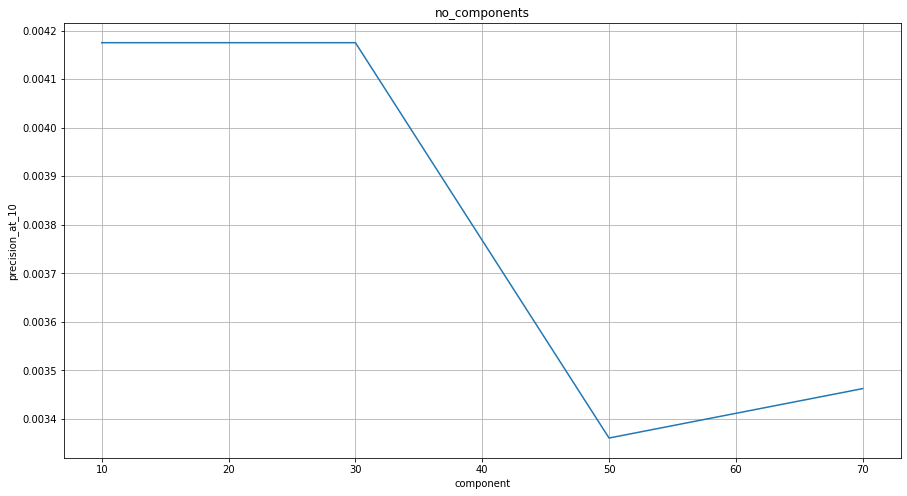

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(x=list_no_components, y=precision_at_10_no_components)
ax.set_title('no_components')
ax.set_xlabel('component')
ax.set_ylabel('precision_at_10')
ax.grid()

plt.show()

In [ ]:
precision_at_10_loss = []
for loss in list_loss:
  lfm_feat_process = LightFM(loss=loss, random_state=7, k=10, no_components=20)
  lfm_feat_process.fit(interactions=interactions_matrix_train, sample_weight=weights_matrix_train, item_features=feat_process)

  precision_at_10_feat_process = precision_at_k(model=lfm_feat_process, test_interactions=interactions_matrix_test, k=10, item_features=feat_process).mean()
  precision_at_10_loss.append(precision_at_10_feat_process)

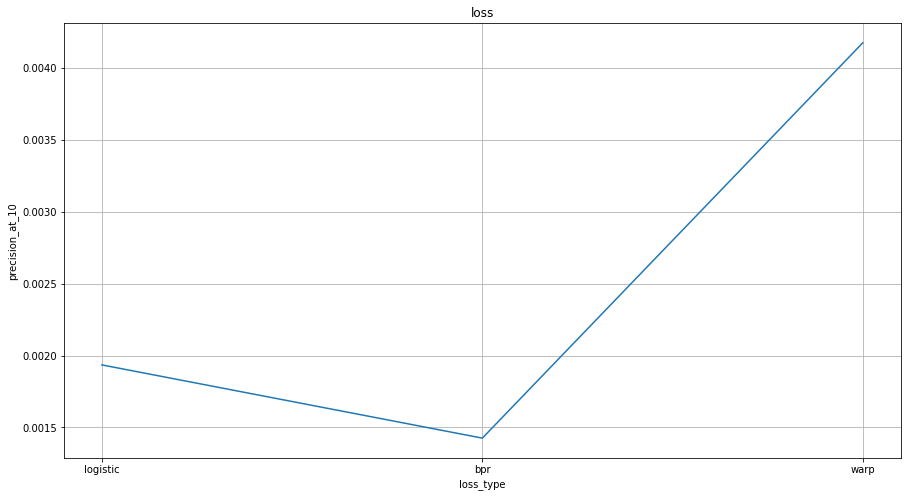

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(x=list_loss, y=precision_at_10_loss)
ax.set_title('loss')
ax.set_xlabel('loss_type')
ax.set_ylabel('precision_at_10')
ax.grid()

plt.show()

In [ ]:
precision_at_10_learning_rates = []
for learning_rate in list_learning_rates:
  lfm_feat_process = LightFM(loss='warp', random_state=7, k=10, no_components=20, learning_rate=learning_rate)
  lfm_feat_process.fit(interactions=interactions_matrix_train, sample_weight=weights_matrix_train, item_features=feat_process)

  precision_at_10_feat_process = precision_at_k(model=lfm_feat_process, test_interactions=interactions_matrix_test, k=10, item_features=feat_process).mean()
  precision_at_10_learning_rates.append(precision_at_10_feat_process)

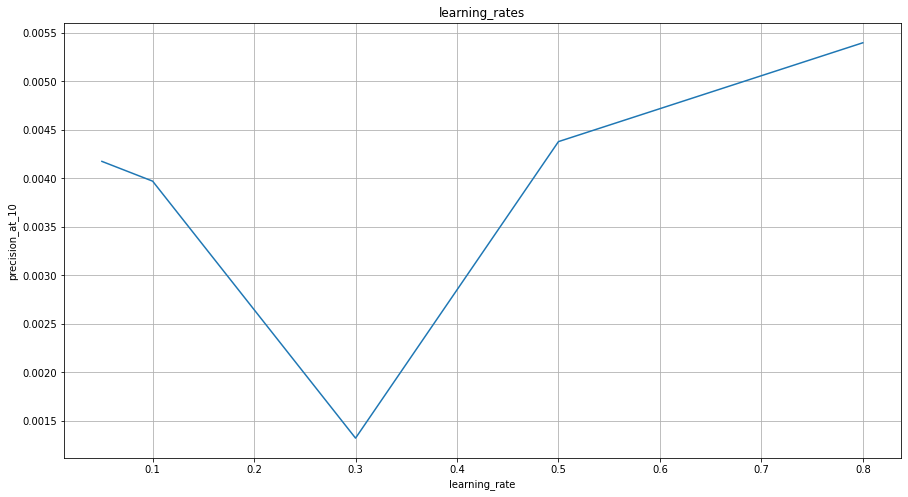

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(x=list_learning_rates, y=precision_at_10_learning_rates)
ax.set_title('learning_rates')
ax.set_xlabel('learning_rate')
ax.set_ylabel('precision_at_10')
ax.grid()

plt.show()

Финальная модель

In [ ]:
lfm_feat_process = LightFM(loss='warp', random_state=7, k=10, no_components=20, learning_rate=0.8)
lfm_feat_process.fit(interactions=interactions_matrix_train, sample_weight=weights_matrix_train, item_features=feat_process)

precision_at_10_feat_process = precision_at_k(model=lfm_feat_process, test_interactions=interactions_matrix_test, k=10, item_features=feat_process).mean()
print(f'precision@10 на тесте после оптимизации гиперпараметров: {precision_at_10_feat_process}')

precision@10 на тесте после оптимизации гиперпараметров: 0.00539714889600873


## Бонусное задание. (3 балла)

Выше мы использовали достаточно простое представление текста статьи в виде TF-IDF. В этом задании Вам нужно представить текст статьи (можно вместе с заголовком) в виде эмбеддинга полученного с помощью рекуррентной сети или трансформера (можно использовать любую предобученную модель, которая Вам нравится). Обучите модель с ипользованием этих эмбеддингов и сравните результаты с предыдущими.

In [1]:
!pip install -U sentence-transformers

     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 2.1MB 5.2MB/s 
     |████████████████████████████████| 1.2MB 18.1MB/s 
     |████████████████████████████████| 3.3MB 26.7MB/s 
     |████████████████████████████████| 901kB 36.2MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=5410cd28644b77ee817b70aa08cb744ee6395ae74278ac5452a1c5d674bb69d1
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers


In [15]:
articles_df_unique_title = articles_df[['contentId', 'title', 'text']].drop_duplicates(ignore_index=True)
articles_df_unique_title

,contentId,title,text
0,-4110354420726924665,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...
1,-7292285110016212249,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...
2,-6151852268067518688,Google Data Center 360° Tour,We're excited to share the Google Data Center ...
3,2448026894306402386,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...
4,-2826566343807132236,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...
...,...,...,...
3042,9213260650272029784,"Conheça a Liga IoT, plataforma de inovação abe...","A Liga Ventures, aceleradora de startups espec..."
3043,-3295913657316686039,Amazon takes on Skype and GoToMeeting with its...,"Amazon has launched Chime, a video conferencin..."
3044,3618271604906293310,Code.org 2016 Annual Report,"February 9, 2017 - We begin each year with a l..."
3045,6607431762270322325,JPMorgan Software Does in Seconds What Took La...,"At JPMorgan Chase & Co., a learning machine is..."


In [18]:
articles_df_unique_title.contentId.count() == articles_df_unique_title.contentId.nunique() # Проверка на то, что в столбце contentId точно находятся уникальные значения

True

In [17]:
articles_df_unique_title['text_title'] = articles_df_unique_title['title'] + ' ' + articles_df_unique_title['text']
articles_df_unique_title

,contentId,title,text,text_title
0,-4110354420726924665,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,"Ethereum, a Virtual Currency, Enables Transact..."
1,-7292285110016212249,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,Bitcoin Future: When GBPcoin of Branson Wins O...
2,-6151852268067518688,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,Google Data Center 360° Tour We're excited to ...
3,2448026894306402386,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,"IBM Wants to ""Evolve the Internet"" With Blockc..."
4,-2826566343807132236,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,IEEE to Talk Blockchain at Cloud Computing Oxf...
...,...,...,...,...
3042,9213260650272029784,"Conheça a Liga IoT, plataforma de inovação abe...","A Liga Ventures, aceleradora de startups espec...","Conheça a Liga IoT, plataforma de inovação abe..."
3043,-3295913657316686039,Amazon takes on Skype and GoToMeeting with its...,"Amazon has launched Chime, a video conferencin...",Amazon takes on Skype and GoToMeeting with its...
3044,3618271604906293310,Code.org 2016 Annual Report,"February 9, 2017 - We begin each year with a l...","Code.org 2016 Annual Report February 9, 2017 -..."
3045,6607431762270322325,JPMorgan Software Does in Seconds What Took La...,"At JPMorgan Chase & Co., a learning machine is...",JPMorgan Software Does in Seconds What Took La...


In [21]:
sentences = articles_df_unique_title.text_title.tolist()

In [22]:
sentences[:10]

['Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin\'s All of this work is still very early. The first full public version of the Ethereum software was recently released, and the system could face some of the same technical and legal problems that have tarnished Bitcoin. Many Bitcoin advocates say Ethereum will face more security problems than Bitcoin because of the greater complexity of the software. Thus far, Ethereum has faced much less testing, and many fewer attacks, than Bitcoin. The novel design of Ethereum may also invite intense scrutiny by authorities given that potentially fraudulent contracts, like the Ponzi schemes, can be written directly into the Ethereum system. But the sophisticated capabilities of the system have made it fascinating to some executives in corporate America. IBM said last year that it was experimenting with Ethereum as a way to control real world objects in the so-called Internet of things. Microsoft has been working on several proje

Сайт, позволивший понять, как использовать модель трансформеров на тексте: https://pypi.org/project/sentence-transformers/

In [23]:
# Ваш код здесь
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [24]:
sentence_embeddings = model.encode(sentences)

In [35]:
sentence_embeddings

array([[ 0.1973576 ,  0.50956154,  0.23380049, ..., -0.39237437,
        -0.0825353 , -0.02109084],
       [ 0.16097409,  0.5209409 , -0.04146318, ..., -0.36265427,
        -0.2625935 ,  0.05058622],
       [ 0.10259512, -0.2960002 , -0.1746758 , ...,  0.14292888,
         0.2668699 ,  0.21371497],
       ...,
       [ 0.08270508,  0.14912824,  0.18687919, ...,  0.65920615,
         0.270247  ,  0.13755783],
       [ 0.17717537,  0.5094814 ,  0.451231  , ..., -0.22586793,
        -0.01641685, -0.08321832],
       [-0.35089543,  0.18360656,  0.12991531, ..., -0.10436612,
         0.23535646,  0.40436813]], dtype=float32)

In [46]:
sentence_embeddings = csr_matrix(sentence_embeddings)
sentence_embeddings

<3047x768 sparse matrix of type '<class 'numpy.float32'>'
	with 2340096 stored elements in Compressed Sparse Row format>

In [26]:
i = 0
for sentence, embedding in zip(sentences, sentence_embeddings):
    if i < 2:
        print("Sentence:", sentence)
        print("Embedding:", embedding)
        print("")
        i += 1
    else:
        break

Sentence: Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's All of this work is still very early. The first full public version of the Ethereum software was recently released, and the system could face some of the same technical and legal problems that have tarnished Bitcoin. Many Bitcoin advocates say Ethereum will face more security problems than Bitcoin because of the greater complexity of the software. Thus far, Ethereum has faced much less testing, and many fewer attacks, than Bitcoin. The novel design of Ethereum may also invite intense scrutiny by authorities given that potentially fraudulent contracts, like the Ponzi schemes, can be written directly into the Ethereum system. But the sophisticated capabilities of the system have made it fascinating to some executives in corporate America. IBM said last year that it was experimenting with Ethereum as a way to control real world objects in the so-called Internet of things. Microsoft has been working on severa

In [48]:
lfm_feat_transformer = LightFM(loss='warp', random_state=7, k=10, no_components=20, learning_rate=0.8)
lfm_feat_transformer.fit(interactions=interactions_matrix_train, sample_weight=weights_matrix_train, item_features=sentence_embeddings)

precision_at_10_feat_transformer = precision_at_k(model=lfm_feat_transformer, test_interactions=interactions_matrix_test, k=10, item_features=sentence_embeddings).mean()
print(f'precision@10 на тесте после применения трансформера: {precision_at_10_feat_transformer}')

precision@10 на тесте после применения трансформера: 0.0057026478461921215


Качество модели с использованием трансформера увеличилось на 4 десятитысячных.